In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H,CNOT,Rzz, RX,DepolarizingChannel,BitFlipChannel,PhaseFlipChannel,\
AmplitudeDampingChannel,PauliChannel,BitPhaseFlipChannel,PhaseDampingChannel
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Image
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

/home/ma-user/anaconda3/envs/Mindquantum-0.9.0/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: Malloc GPU memory failed: cudaErrorInsufficientDriver, CUDA driver version is insufficient for CUDA runtime version
  from .available_simulator import SUPPORTED_SIMULATOR


[(0, 1), (0, 4), (0, 3), (0, 2), (0, 5), (1, 2), (1, 5), (1, 4), (1, 3), (2, 4), (2, 3), (2, 5), (4, 3), (4, 5), (3, 5)]


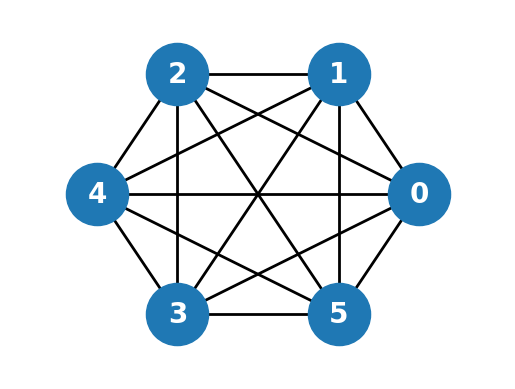

<Figure size 640x480 with 0 Axes>

In [25]:
#绘制k-正则图
n=6
k=n-1
V = [] # 顶点集合
for i in range(0,n):
    V.append(i)
# 正则度k(k需为偶数)，顶点数n
graph = nx.random_graphs.random_regular_graph(k,n)  #生成包含n个节点、每个节点有k个邻居的规则图RG
print(graph.edges)
# 将生成的图 G 打印出来
pos = nx.circular_layout(graph)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(graph, pos, **options)
# graph
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()
save_path="data/SK graph with 6 nodes.png"
plt.savefig(save_path,dpi=600,format="png")

In [3]:
# #生成随机图
# # 随机生成n个节点的图

# n= 5
# G = nx.Graph()			#建立无向图
# H = nx.path_graph(n)	#添加节点，10个点的无向图
# G.add_nodes_from(H)		#添加节点
 
# def rand_edge(vi,vj,p=0.6):		#默认概率p=0.1
#     # probability =random.random()#生成随机小数
#     if(probability>p):			#如果大于p
#         G.add_edge(vi,vj)  		#连接vi和vj节点
# i=0
# while (i<10):
#     j=0
#     while(j<i):
#             rand_edge(i,j)		#调用rand_edge()
#             j +=1
#     i +=1
# # 将生成的图 G 打印出来
# pos = nx.circular_layout(G)
# options = {
#     "with_labels": True,
#     "font_size": 20,
#     "font_weight": "bold",
#     "font_color": "white",
#     "node_size": 2000,
#     "width": 2
# }
# graph=nx.draw_networkx(G, pos, **options)
# ax = plt.gca()
# ax.margins(0.20)
# plt.axis("off")
# plt.show()


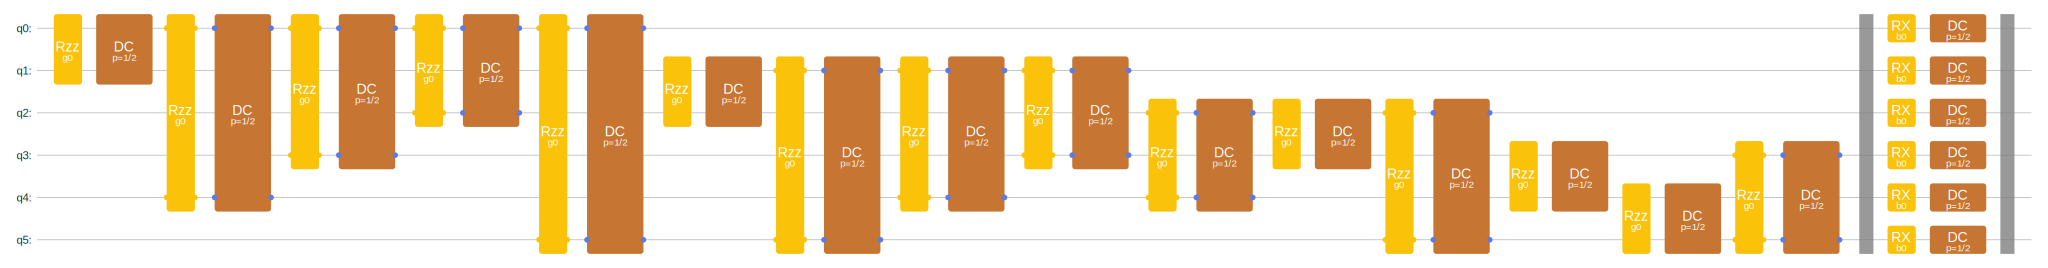

In [4]:
p1=0.5
#去极化信道
def build_hc_dep(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=DepolarizingChannel(p1,2).on(i)
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_dep(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit() 
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=DepolarizingChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_dep(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_dep(g,f'g{i}')
        circ+=build_hb_dep(g,f'b{i}')
    return circ
circ=build_ansatz_dep(graph,1)
circ.svg()

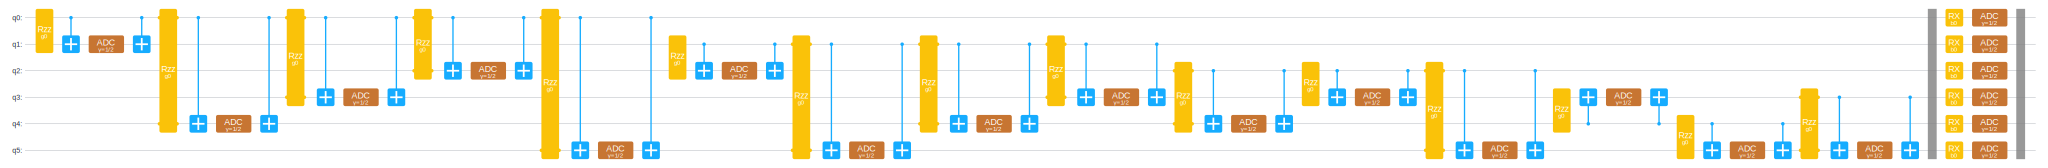

In [5]:
p1=0.5
#振幅阻尼信道
def build_hc_amp(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=AmplitudeDampingChannel(p1).on(i[1])
        hc+=CNOT.on(i[1],i[0])
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_amp(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=AmplitudeDampingChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_amp(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_amp(g,f'g{i}')
        circ+=build_hb_amp(g,f'b{i}')
    return circ
circ=build_ansatz_amp(graph,1)
circ.svg()

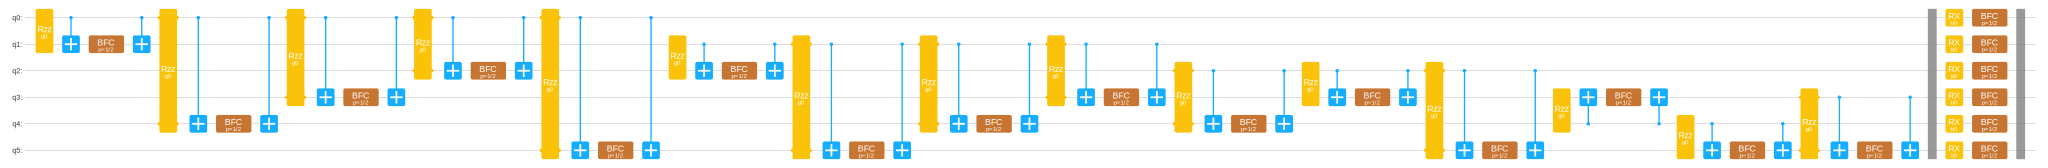

In [6]:
from mindquantum.core.gates import BitFlipChannel,CNOT
p1=0.5
#比特翻转信道信道
def build_hc_bf(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=BitFlipChannel(p1).on(i[1])
        hc+=CNOT.on(i[1],i[0])
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_bf(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=BitFlipChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_bf(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_bf(g,f'g{i}')
        circ+=build_hb_bf(g,f'b{i}')
    return circ
circ=build_ansatz_bf(graph,1)
circ.svg()

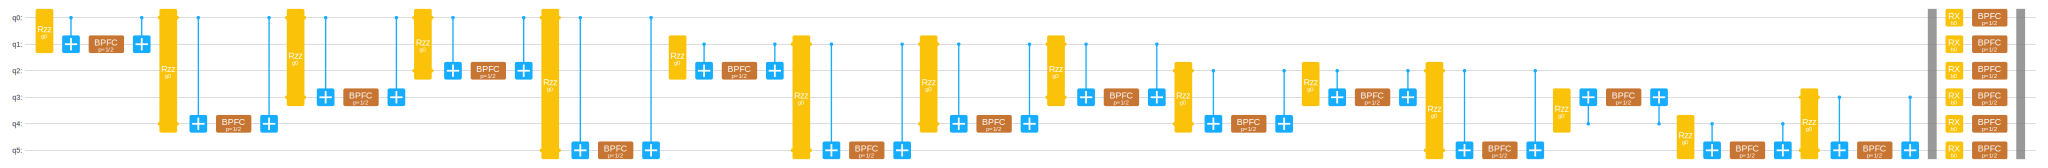

In [7]:
from mindquantum.core.gates import BitPhaseFlipChannel,CNOT
p1=0.5
#比特相位翻转信道
def build_hc_bp(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=BitPhaseFlipChannel(p1).on(i[1])
        hc+=CNOT.on(i[1],i[0])
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_bp(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=BitPhaseFlipChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_bp(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_bp(g,f'g{i}')
        circ+=build_hb_bp(g,f'b{i}')
    return circ
circ=build_ansatz_bp(graph,1)
circ.svg()

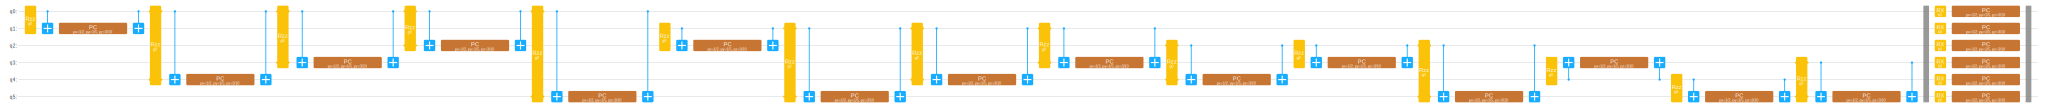

In [8]:
from mindquantum.core.gates import PauliChannel,CNOT
p1=0.5
p2=0.2
p3=1-p1-p2
#Pauli信道
def build_hc_p(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=PauliChannel(p1,p2,p3).on(i[1])
        hc+=CNOT.on(i[1],i[0])

    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_p(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=PauliChannel(p1,p2,p3).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_p(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_p(g,f'g{i}')
        circ+=build_hb_p(g,f'b{i}')
    return circ
circ=build_ansatz_p(graph,1)
circ.svg()

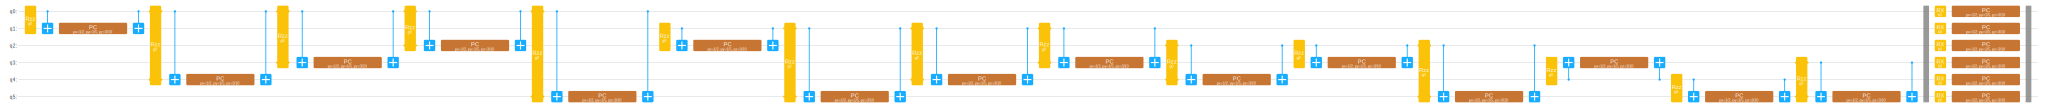

In [9]:
from mindquantum.core.gates import PhaseDampingChannel,CNOT
p1=0.5
#相位阻尼信道
def build_hc_pd(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=PhaseDampingChannel(p1).on(i)
        hc+=CNOT.on(i[1],i[0])
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_pd(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=PhaseDampingChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_pd(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_pd(g,f'g{i}')
        circ+=build_hb_pd(g,f'b{i}')
    return circ
circ=build_ansatz_p(graph,1)
circ.svg()

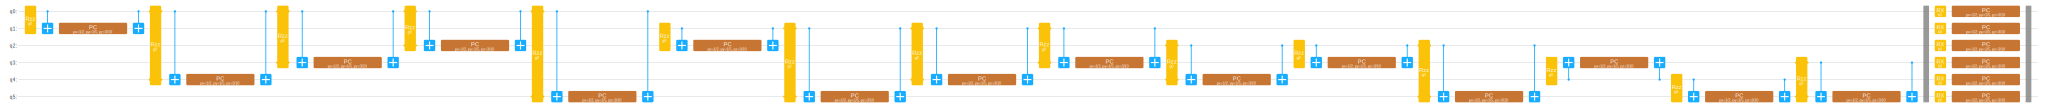

In [10]:
from mindquantum.core.gates import PhaseFlipChannel,CNOT
p1=0.5
#相位翻转信道
def build_hc_pf(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hc=Circuit()
    for i in g.edges:
        hc+=Rzz(para).on(i)
        hc+=CNOT.on(i[1],i[0])
        hc+=PhaseFlipChannel(p1).on(i[1])
        hc+=CNOT.on(i[1],i[0])
    hc.barrier()
    return hc
#搭建U_B(beta)对应的量子线路
def build_hb_pf(g,para):#根据已知含参无向图，创建Ansatz电路，划分为hc和hb两个电路门
    hb=Circuit()
    for i in g.nodes:
        hb+=RX(para).on(i)
        hb+=PhaseFlipChannel(p1).on(i)
    hb.barrier()
    return hb
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_pf(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        circ+=build_hc_pf(g,f'g{i}')
        circ+=build_hb_pf(g,f'b{i}')
    return circ
circ=build_ansatz_p(graph,1)
circ.svg()

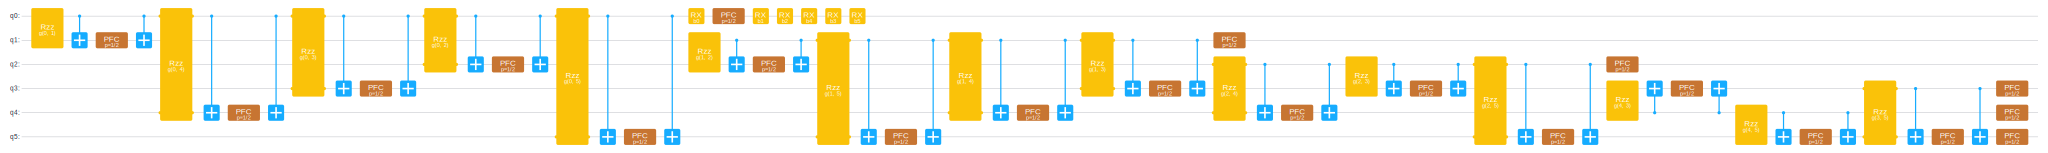

In [11]:
from mindquantum.core.gates import PhaseFlipChannel,CNOT
p1=0.5
#相位翻转信道
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
def build_ansatz_pf(g,p):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    for i in range(p):
        for j in g.edges:
            circ+=Rzz(f'g{j}').on(j)
            circ+=CNOT.on(j[1],j[0])
            circ+=PhaseFlipChannel(p1).on(j[1])
            circ+=CNOT.on(j[1],j[0])
        for j in g.nodes:
            circ+=RX(f'b{j}').on(i)
            circ+=PhaseFlipChannel(p1).on(j)
    return circ
circ=build_ansatz_pf(graph,1)
circ.svg()

In [12]:
#构建图对应的哈密顿量Hc
def build_ham(g):
    ham=QubitOperator()
    for i in g.edges:
        ham+=QubitOperator(f'Z{i[0]} Z{i[1]}')
    return ham
def get_expectation_of_hamitonian(circ, qubit, ham, pr):

    sim = Simulator('mqvector', qubit)
    sim.apply_circuit(circ, pr)
    result = sim.get_expectation(ham)
    # energy[k] = result.real

    return result.real
# 搭建哈密顿量。

def max_cut(ham_operator):

    # 首先根据哈密顿量的算符将其转化为矩阵形式。
    ham_matrix = ham_operator.matrix()
    ham_matrix = ham_matrix.todense()

    # calculate the eigenvalue and eigenvector
    eigval, eigvec = np.linalg.eig(ham_matrix)

    # ground energy
    min_cut_val = min(eigval).real

    return min_cut_val

In [13]:
#为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：
p1=0.5
p2=0.2
def build_ansatz(qubit,layer,graph,problem):#g是max-cut问题的图，p是ansatz线路的层数
    circ=Circuit()
    if problem=='ideal_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
    if problem=='depolarizing_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=DepolarizingChannel(p1,2).on(j)
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=DepolarizingChannel(p1).on(j)
    if problem=='amplitudedamping_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=AmplitudeDampingChannel(p1).on(j[1])
                circ+=CNOT.on(j[1],j[0])
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=AmplitudeDampingChannel(p1).on(j)
    if problem=='bitflip_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=BitFlipChannel(p1).on(j[1])
                circ+=CNOT.on(j[1],j[0])

            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=BitFlipChannel(p1).on(j)
    if problem=='bitphaseflip_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=BitPhaseFlipChannel(p1).on(j[1])
                circ+=CNOT.on(j[1],j[0])
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=BitPhaseFlipChannel(p1).on(j)
    if problem=='pauli_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=PauliChannel(p1,p2,1-p1-p2).on(j[1])
                circ+=CNOT.on(j[1],j[0])
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=PauliChannel(p1,p2,1-p1-p2).on(j)
    if problem=='phasedamping_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=PhaseDampingChannel(p1).on(j[1])
                circ+=CNOT.on(j[1],j[0])
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=PhaseDampingChannel(p1).on(j)

    if problem=='phaseflip_channel':
        for i in range(layer):
            for j in graph.edges:
                circ+=Rzz(f'g{j}').on(j)
                circ+=CNOT.on(j[1],j[0])
                circ+=PhaseFlipChannel(p1).on(j[1])
                circ+=CNOT.on(j[1],j[0])
            for j in range(qubit):
                circ+=RX(f'b{j}').on(j)
                circ+=PhaseFlipChannel(p1).on(j)

    return circ




In [14]:
#训练不同类型的信道电路
def train(g, qubit, p, ham, problem):
    """
    g: max cut 的图
    qubit: 输入量子比特的数目
    p: 线路的层数
    ham: 问题哈密顿量
    problem:  "ideal_model" 或者 "noise_model"

    """

    # bulid the quantum circuit
    init_state_circ = UN(H, qubit)                                  # 生成均匀叠加态，即对所有量子比特作用H门
    if problem == "ideal_channel":
        ansatz = build_ansatz(qubit, p, g, problem)   # 生成 QAOA-ansat理想线路
    if problem == "amplitudedamping_channel":
        ansatz= build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-amplitudedamping线路
    if problem == "depolarizing_channel":
        ansatz = build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-depolarizing线路
    if problem == "bitflip_channel":
        ansatz= build_ansatz(qubit, p, g,problem)   # 生成 QAOA-ansatz-bitflip线路
    if problem == "bitphaseflip_channel":
        ansatz= build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-bitphaseflip线路
    if problem == "pauli_channel":
        ansatz= build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-pauli线路
    if problem == "phasedamping_channel":
        ansatz = build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-phasedamping线路
    if problem == "phaseflip_channel":
        ansatz= build_ansatz(qubit, p, g, problem) # 生成 QAOA-ansat-phasedamping线路
   #理想环境训练
    circ = init_state_circ + ansatz                               # 将初始化线路与ansatz线路组合成一个线路
        # optimize the parameters
    sim = Simulator('mqvector', circ.n_qubits)

    grad_ops= sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    net= MQAnsatzOnlyLayer(grad_ops)
    opti = nn.Adam(net.trainable_params(), learning_rate=0.1)
    train_net = nn.TrainOneStepCell(net, opti)
    for i in range(300):
        train_net()                                            # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    pr= dict(zip(ansatz.params_name, net.weight.asnumpy()))   # 获取线路参数
    return circ, pr

In [15]:
#最大割求解（全连接图）
qubits = [3,4,5,6,7,8,9,10]#共8例
instance =5#实例次数
Approxi_ratio_i= [0]*instance*len(qubits)
Approxi_ratio_amp= [0]*instance*len(qubits)
Approxi_ratio_dep= [0]*instance*len(qubits)
Approxi_ratio_bf= [0]*instance*len(qubits)
Approxi_ratio_bpf= [0]*instance*len(qubits)
Approxi_ratio_p= [0]*instance*len(qubits)
Approxi_ratio_pd= [0]*instance*len(qubits)
Approxi_ratio_pf= [0]*instance*len(qubits)

k=0
p=1#线路层次
p1=0.5#噪声系数
for qubit in tqdm(qubits):
    # 取5中不同的 3-Regular MaxCut 图取均值
    for i in range(instance):
        maxcut_graph=nx.random_regular_graph(n=qubit, d = qubit-1) #产生边为d的全连接图
        ham_operator=build_ham(maxcut_graph)
        max_cut_val=max_cut(ham_operator)
        ham=Hamiltonian(ham_operator)
        #---------------------------------------------------
        # 通过 理想QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p, ham, "ideal_channel")
        expectation = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_i[k] = expectation/max_cut_val

        #---------------------------------------------------
        # 通过 振幅阻尼amp-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "amplitudedamping_channel")
        expectation_2 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_amp[k] = expectation_2/max_cut_val
        #---------------------------------------------------
        # 通过 去极化depolarizing-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "depolarizing_channel")
        expectation_3 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_dep[k] = expectation_3/max_cut_val
        #---------------------------------------------------
        # 通过 bitflip-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "bitflip_channel")
        expectation_4 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_bf[k] = expectation_4/max_cut_val
        #---------------------------------------------------
        # 通过 bitphaseflip-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "bitphaseflip_channel")
        expectation_5 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_bpf[k] = expectation_5/max_cut_val
        #---------------------------------------------------
        # 通过 振幅阻尼amp-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "pauli_channel")
        expectation_6 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_p[k] = expectation_6/max_cut_val
        #---------------------------------------------------
        # 通过 振幅阻尼amp-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "phasedamping_channel")
        expectation_7 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_pd[k] = expectation_7/max_cut_val
        #---------------------------------------------------
        # 通过 振幅阻尼amp-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "phaseflip_channel")
        expectation_8 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_bf[k] = expectation_8/max_cut_val
        k += 1
        # print(ham_operator)


100%|██████████| 8/8 [16:33<00:00, 124.13s/it]


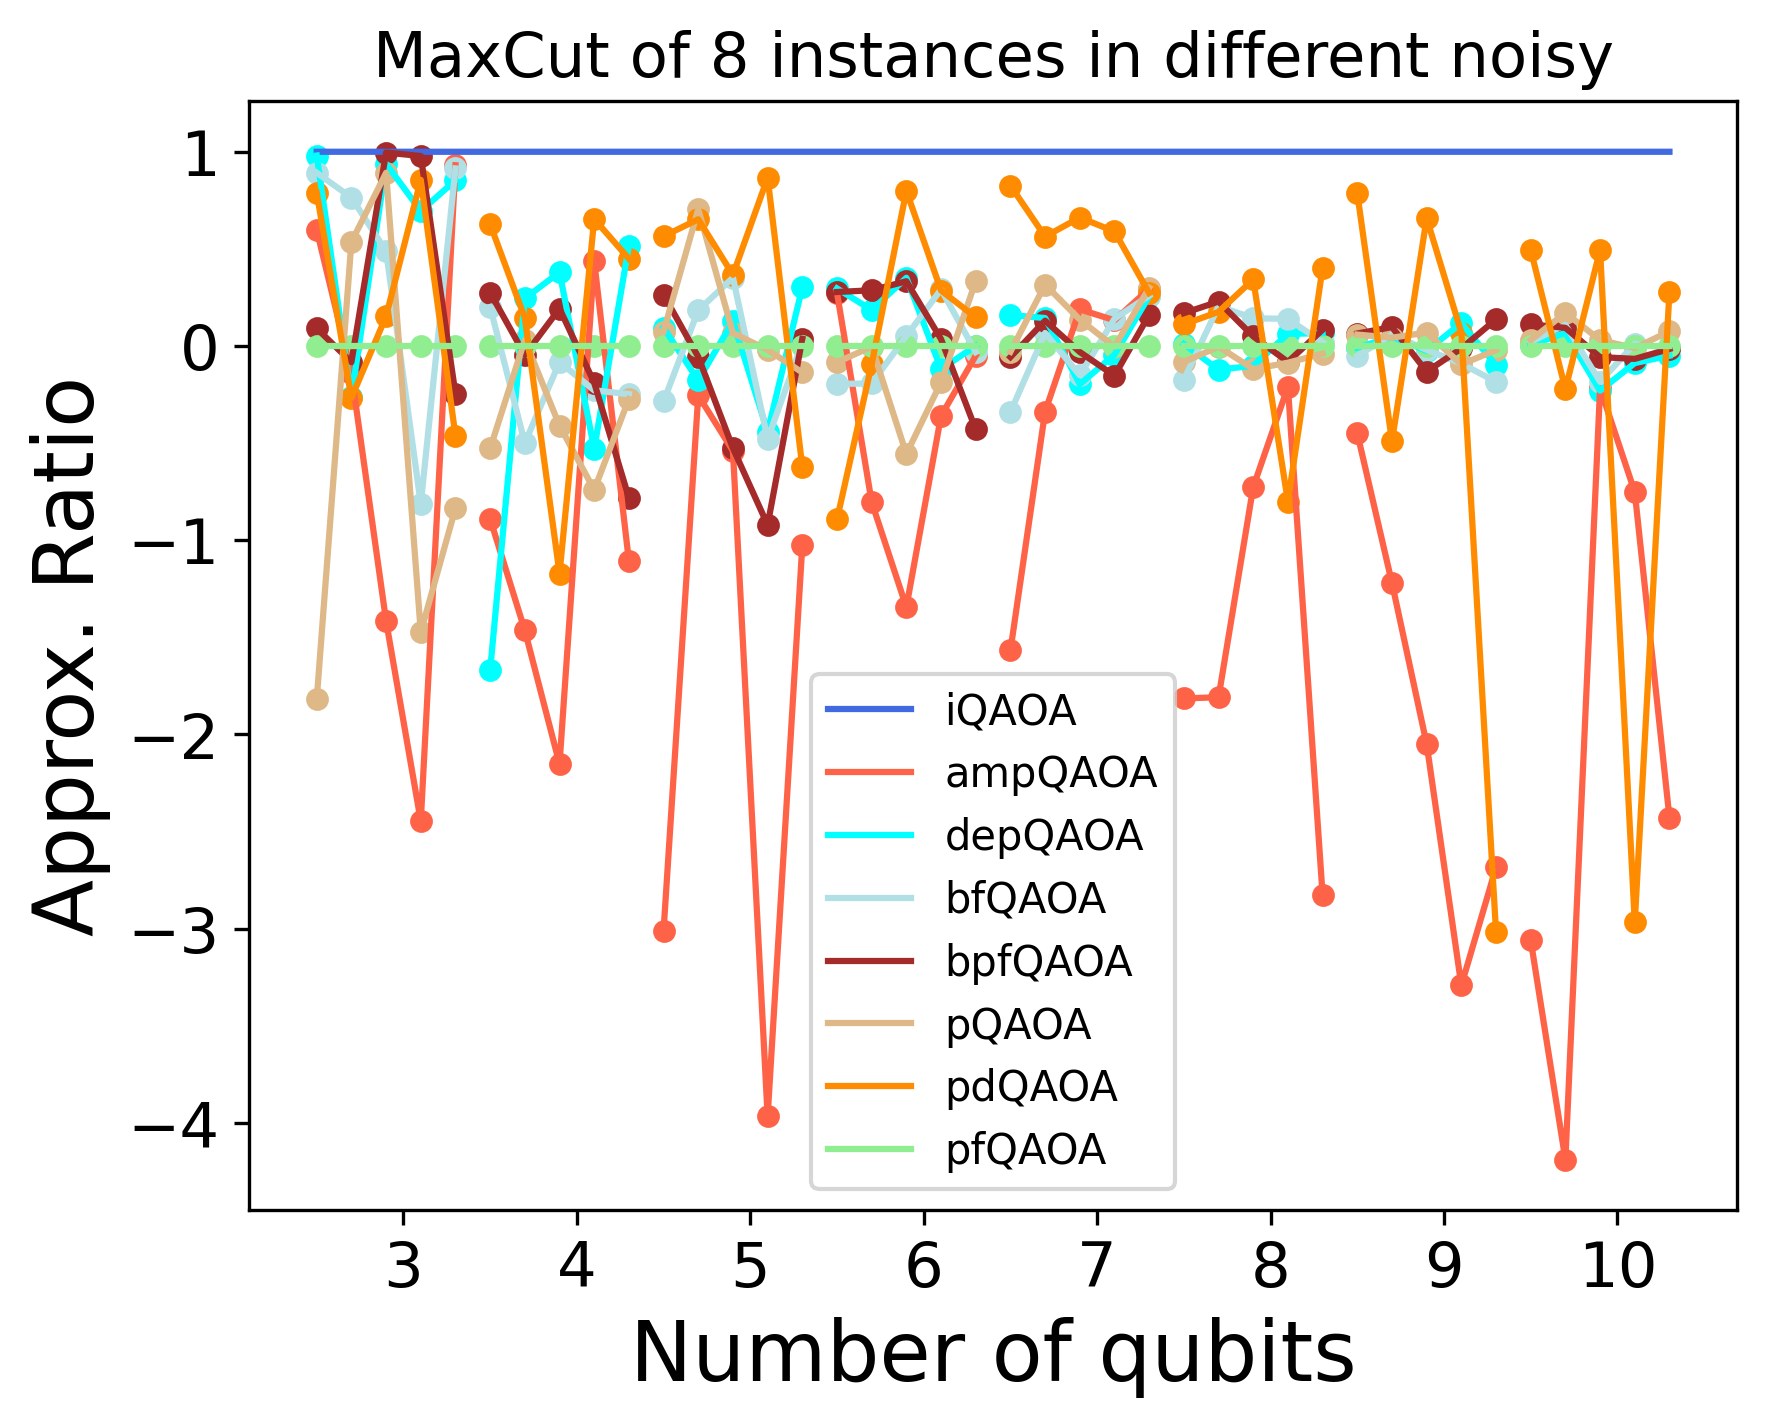

<Figure size 640x480 with 0 Axes>

In [24]:
#量子边数、qubits对AR的影响
plt.figure(1, dpi=300)
#plt.plot(range(5*i,5*i+5),Approxi_ratio_i[5*i:5*(i+1)] , color='royalblue', label="iQAOA")
plt.plot(range(0,40),Approxi_ratio_i[0:40] , color='royalblue', label="iQAOA")
    #plt.scatter(range(8*i,8*i+8), Approxi_ratio_i[8*i:8*(i+1)] , color='royalblue')
for i in range(8):
    plt.plot(range(5*i,5*i+5), Approxi_ratio_amp[5*i:5*(i+1)], color='tomato', label="ampQAOA")
    #plt.plot(range(5*i,5*i+1), Approxi_ratio_amp[5*i:5*i+1], color='darkorange')
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_amp[5*i:5*(i+1)], color='tomato',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_dep[5*i:5*(i+1)], color='aqua', label="depQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_dep[5*i:5*(i+1)], color='aqua',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_bf[5*i:5*(i+1)], color='powderblue', label="bfQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_bf[5*i:5*(i+1)], color='powderblue',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_bpf[5*i:5*(i+1)], color='brown', label="bpfQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_bpf[5*i:5*(i+1)], color='brown',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_p[5*i:5*(i+1)], color='burlywood', label="pQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_p[5*i:5*(i+1)], color='burlywood',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_pd[5*i:5*(i+1)], color='darkorange', label="pdQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_pd[5*i:5*(i+1)], color='darkorange',s=20)
    plt.plot(range(5*i,5*i+5), Approxi_ratio_pf[5*i:5*(i+1)], color='lightgreen', label="pfQAOA")
    plt.scatter(range(5*i,5*i+5), Approxi_ratio_pf[5*i:5*(i+1)], color='lightgreen',s=20)
    
    
    plt.xticks([2.5, 7.5, 12.5, 17.5, 22.5,27.5,32.5,37.5], ['3','4','5','6','7','8','9','10'], fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Approx. Ratio', fontsize=20)
    plt.xlabel('Number of qubits', fontsize=20)
    plt.title("MaxCut of 8 instances in different noisy", fontsize=15)
    if i == 0:
        plt.legend(fontsize=10)
# for i in range(8):
#     plt.plot(range(5*i,5*i+1), Approxi_ratio_amp[5*i:5*i+1], color='darkorange', label="ampQAOA")

plt.show()
save_path="data/approximate ratio comparison with difference noisy.png"
plt.savefig(save_path,dpi=600,format="png")

In [17]:
p=4
ham=Hamiltonian(build_ham(graph))
init_state_circ=UN(H,graph.nodes)
ansatz=build_ansatz(graph,p)
circ=init_state_circ+ansatz
circ.svg(width=1200)

TypeError: build_ansatz() missing 2 required positional arguments: 'graph' and 'problem'

In [ ]:
#选择p = 4，表示选用4层的QAOA量子线路，ansatz是求解该问题的量子线路，init_state_circ是将量子态制备到均匀叠加态（HB的基态）上的量子线路


#1)利用传统优化算法完成优化搜索
sim=Simulator('mqvector',circ.n_qubits)
grad_opts=sim.get_expectation_with_grad(ham,circ)
#利用模拟器生成计算QAOA变分量子线路期望值和梯度的运算算子。

#通过如下方式计算线路在参数为10个随机生成 p0 时的期望值和导数。
import numpy as np
rng=np.random.default_rng(10)
p0=rng.random(size=len(circ.params_name))*np.pi*2-np.pi
f,g=grad_opts(p0)
print('Expectation Value: ', f)
#期望值是一个(1,1)维的数组，其中m表示本次运算将多少数据通过编码器编码成了量子态，由于QAOA任务不用编码器，因此m
#取默认值1，n表示本次运算计算了多少个哈密顿量期望值（MindQuantum支持多哈密顿量并行处理），此处我们只计算了ham的期望值
print('Expectation Value Shape: ', f.shape)
print('Gradient: ', g)
#对于梯度值来说，它的维度是(1, 1, 8)，新增的维度k=8表示整个线路中的ansatz变分参数个数。g0-g3和b0-b3
print('Gradient Shape: ', g.shape)

In [ ]:
#2)引入scipy中的二阶优化器BFGS来对Max-Cut问题进行优化，为此首先定义待优化函数
global step
step=0
def fun(p,grad_opts):
    global step
    f,g=grad_opts(p)
    f=np.real(f)[0,0]
    g=np.real(g)[0,0]
    step+=1
    if step%10==0:
        print(f"train step:{step},cut:[{(len(graph.edges)-f)/2}]")
    return f,g
fun(p0,grad_opts)
#采用BFGS的二阶优化方法，指定jac=True，表示告诉优化器，待优化的函数在返回函数值的同时也会返回梯度值。如设定为False，优化器会利用差分法自行计算近似梯度，这会消耗大量算力。

In [ ]:
from scipy.optimize import minimize

step = 0
res = minimize(fun, p0, args=(grad_opts, ), method='bfgs', jac=True)

print(dict(zip(circ.params_name, res.x)))
#在最优解时，训练得到的变分参数为

In [ ]:
#3)利用 MindSpore 机器学习框架完成量子神经网络训练
#搭建待训练量子神经网络
#使用MQAnsatzOnlyLayer作为待训练的量子神经网络，并采用Adam优化器。

import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE,device_target='CPU')
sim=Simulator('mqvector',circ.n_qubits) # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops=sim.get_expectation_with_grad(ham,circ) # 获取sim计算变分量子线路的期望值和梯度的算子

net=MQAnsatzOnlyLayer(grad_ops)# # 生成待训练的神经网络

In [ ]:
## Adam同时使用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。 一阶矩来控制模型更新的方向，二阶矩控制步长(学习率)。
max_cuts=[]
opti1=nn.Adam(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net1=nn.TrainOneStepCell(net,opti1)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net1())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr1=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio1=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio1)
mean_ratio1 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio1)

In [ ]:
opti2=nn.SGD(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net2=nn.TrainOneStepCell(net,opti2)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net2())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr2=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio2=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio2)
mean_ratio2 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio2)

In [ ]:
#Momentum通过将当前梯度与过去梯度加权平均，来获取即将更新的梯度，有助于在相关方向上加速SGD并抑制振荡。
opti3=nn.Momentum(net.trainable_params(),learning_rate=0.05,momentum=0.9, weight_decay=0.0) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net3=nn.TrainOneStepCell(net,opti3)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net3())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr3=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio3=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio3)
mean_ratio3 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio3)

In [ ]:
opti4=nn.Adagrad(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net4=nn.TrainOneStepCell(net,opti4)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net4())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr4=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio4=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio4)
mean_ratio4 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio4)

In [ ]:

opti5=nn.Adadelta(net.trainable_params(),learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net5=nn.TrainOneStepCell(net,opti5)# 对神经网络采用设定优化器opti进行一步训练
#训练，展示max_cut问题求解
for i in range(300):
    cut=(len(graph.edges)-train_net5())/2
    if i%10==0:
        print("train step:",i,",cut:",cut)
        cut=cut.numpy()
        max_cuts.append(cut)
#该问题哈密顿量的基态能量对应的边切割数趋近于6。

pr5=dict(zip(ansatz.params_name,net.weight.asnumpy()))
mean_max_cuts = np.mean(max_cuts)
max_max_cuts=np.max(max_cuts)
print("最大割：",max_max_cuts)
max_ratio5=max_max_cuts/mean_max_cuts_classical
print("最大近似比率：",max_ratio4)
mean_ratio4 = mean_max_cuts/mean_max_cuts_classical
print("平均近似比率：",mean_ratio4)

In [ ]:
# #https://blog.csdn.net/xian0710830114/article/details/128658682
# # import torch
# # import torch.utils.data as Data
# # import torch.nn.functional as F
# # from torch.autograd import Variable
# import matplotlib.pyplot as plt

# BATCH_SIZE = 32
# EPOCH = 120

# LR = 0.5
# # 生成假数据
# # # torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
# # x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  # x data (tensor), shape(100, 1)
# # # 0.2 * torch.rand(x.size())增加噪点
# # y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
 
# # # 定义数据库
# # dataset = Data.TensorDataset(x, y)
 
# # # 定义数据加载器
# # loader = Data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# # 定义不同的优化器网络
# net_SGD = MQAnsatzOnlyLayer(grad_ops)#带动量 的SGD 优化算法，Momentum通过将当前梯度与过去梯度加权平均，来获取即将更新的梯度，有助于在相关方向上加速SGD并抑制振荡。
# net_Momentum =  MQAnsatzOnlyLayer(grad_ops)#同上
# net_Adam=  MQAnsatzOnlyLayer(grad_ops)#同时使用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。 一阶矩来控制模型更新的方向，二阶矩控制步长(学习率)。
# net_Adadelta=  MQAnsatzOnlyLayer(grad_ops)#  对于每个维度,用梯度平方的指数加权平均代替了全部梯度的平方和,避免了后期更新时更新幅度逐渐趋近于0的问题。用更新量的平方的指数加权平均来动态得代替了全局的标量的学习率,避免了对学习率的敏感。
# net_Adagrad= MQAnsatzOnlyLayer(grad_ops)# 每个时间步长对每个参数使用不同的学习率。 引入了梯度的二阶矩，二阶矩是迄今为止所有梯度值的平方和，二阶矩的越大，代表步长的不确定性越大，学习率就越小，反之学习率越大。
# net_RMSprop = MQAnsatzOnlyLayer(grad_ops)#与Adadelta同一时期，等价于实现了Adadelta的第一个改动。
# net_Adamax = MQAnsatzOnlyLayer(grad_ops)# 在Adam的基础上，为学习率的上限限制了范围。将Adam的二范数（二阶矩估计）推广到无穷范数，因为无穷范数，就是取向量的最大值，这就为学习率的上限提供了一个更简单的范围。
# net_AdamW = MQAnsatzOnlyLayer(grad_ops)# 使用adam+权重衰减的方式解决了adam+L2正则化表现不佳的问题。

# # 选择不同的优化方法
# #opt_SGD=nn.SGD(net_SGD)
# # opt_SGD = nn.SGD(net_SGD.trainable_params(), lr=LR)
# opt_SGD = nn.SGD(net_SGD.trainable_params(), learning_rate=LR)
# opt_Momentum = nn.Momentum(net_Momentum.trainable_params(), learning_rate=LR, momentum=0.9)
# opt_Adagrad = nn.Adagrad(net_Adagrad.trainable_params(), learning_rate=LR)
# opt_Adadelta = nn.Adadelta(net_Adadelta.trainable_params(), learning_rate=LR)
# opt_RMSprop = nn.RMSprop(net_RMSprop.trainable_params(), learning_rate=LR, alpha=0.9)
# opt_Adam = nn.Adam(net_Adam.trainable_params(), learning_rate=LR, betas=(0.9, 0.99))
# opt_Adamax =nn.Adamax(net_Adamax.trainable_params(), learning_rate=LR, betas=(0.9, 0.99))
# opt_AdamW = nn.AdamW(net_AdamW.trainable_params(), learning_rate=LR, betas=(0.9, 0.99))
# #opt_BFGS =nn.LBFGS(net_LBFGS.parameters(), lr=LR, max_iter=10, max_eval=10)

# nets = [net_SGD, net_Momentum, net_Adam, net_Adadelta,net_Adagrad, net_RMSprop,  net_Adamax, net_AdamW]
# optimizers = [opt_SGD, opt_Momentum, opt_Adagrad, opt_Adam,opt_Adadelta, opt_Adagrad,opt_RMSprop,  opt_Adamax, opt_AdamW]
# #选定损失函数
# loss_func =nn.MSELoss()#用于计算预测值与标签值之间的均方误差。
# # 不同方法的loss
# loss_SGD = []
# loss_Momentum = []
# loss_Adagrad = []
# loss_Adadelta = []
# loss_RMSprop = []
# loss_Adam = []
# loss_Adamax = []
# loss_AdamW = []
# # 保存所有loss
# losses = [loss_SGD, loss_Momentum, loss_Adagrad, loss_Adadelta, loss_RMSprop, loss_Adam, loss_Adamax, loss_AdamW]
# # 执行训练
# for epoch in range(500):
#     for net, optimizer, loss_history in zip(nets, optimizers, losses):
#             if isinstance(optimizer, nn.Adam):
#                 def closure():
#                     #y_pred = net(var_x)
#                     loss = loss_func(y_pred, var_y)
#                     optimizer.zero_grad()
#                     loss.backward()
#                     return loss
#                 loss = optimizer.step(closure)
#             else:
#                 # 对x进行预测
#                 prediction = net(var_x)
#                 # 计算损失
#                 loss = loss_func(prediction, var_y)
#                 # 每次迭代清空上一次的梯度
#                 optimizer.zero_grad()
#                 # 反向传播
#                 loss.backward()
#                 # 更新梯度
#                 optimizer.step()
#             # 保存loss记录
#             loss_history.append(loss.data)
